# MNE Tutorial
Process and analyze EEG signals using Python!
## Installation

In [84]:
import os
import numpy as np
import mne

## Load Data
We are going to use sample data provided by MNE that is accessible through data_path() function. In this specific dataset, the subjects were doing an audiovisual experiment. Specifically, in the experiment, checkerboard patterns were presented to the subject into the left and right visual field, interspersed by tones to the left or right ear. The interval between the stimuli was 750 ms. Occasionally a smiley face was presented at the center of the visual field. The subject was asked to press a key with the right index finger as soon as possible after the appearance of the face.

Data can be in multiple file formats, specifically for this dataset we are using fif, which is the raw MEG/EEG data.

In [85]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = (sample_data_folder / 'MEG' / 'sample' /
                        'sample_audvis_filt-0-40_raw.fif')
raw = mne.io.read_raw_fif('sample_audvis_filt-0-40_raw.fif')

Opening raw data file sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


The MNE Python library also is used to process magnetoencephalography (MEG) signals, but today we shall focus solely on analyzing and processing EEGs. We can do this simply by picking the types as follows:

In [86]:
raw = raw.pick_types(meg=False, eeg=True, eog=False, exclude='bads')

Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>


In [87]:
print(raw.info)

<Info | 14 non-empty values
 bads: []
 ch_names: EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, EEG 007, ...
 chs: 59 EEG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 59
 projs: Average EEG reference: off
 sfreq: 150.2 Hz
>


## Plotting
We can use the EEG signals to plot as follows:

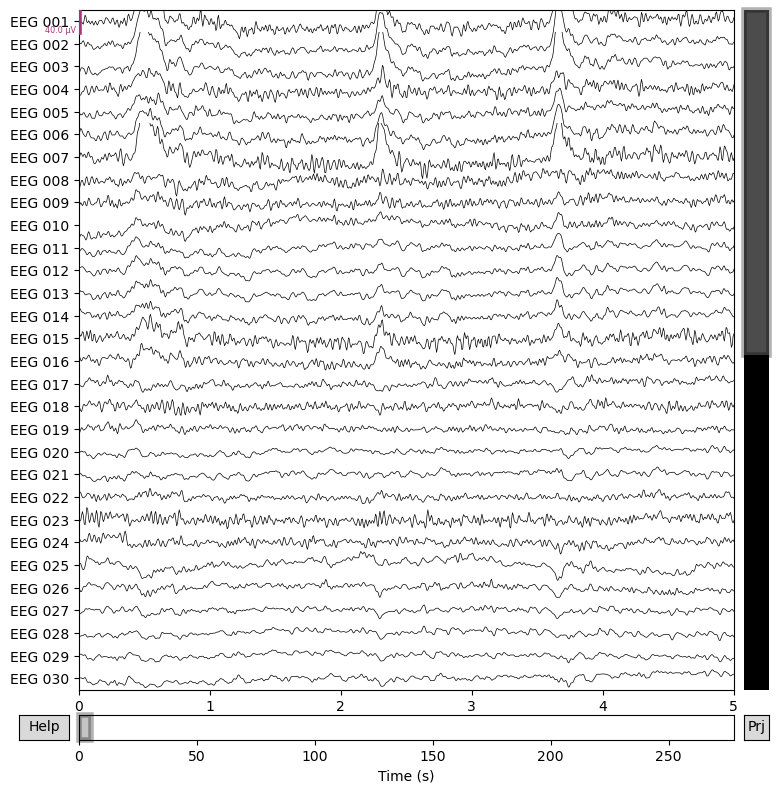

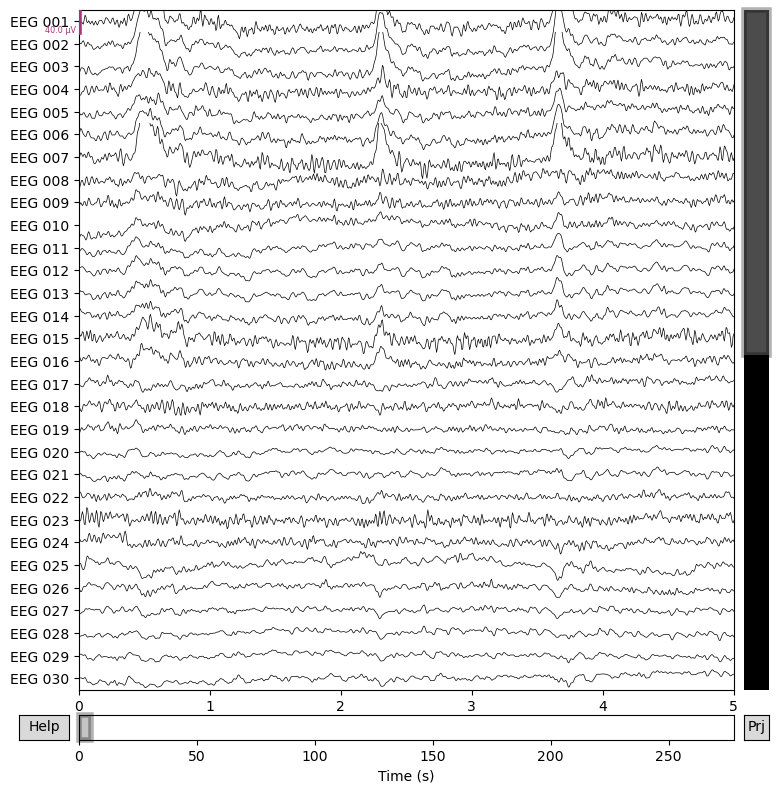

In [88]:
# the parameters are used to specify and limit data being processed
raw.plot(duration=5, n_channels=30)

Another plot available is for power spectral density (PSD), which specifies the power levels of the frequency components present in a signal.

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 13.639 (s)


/Users/xinyitheresexu/opt/anaconda3/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


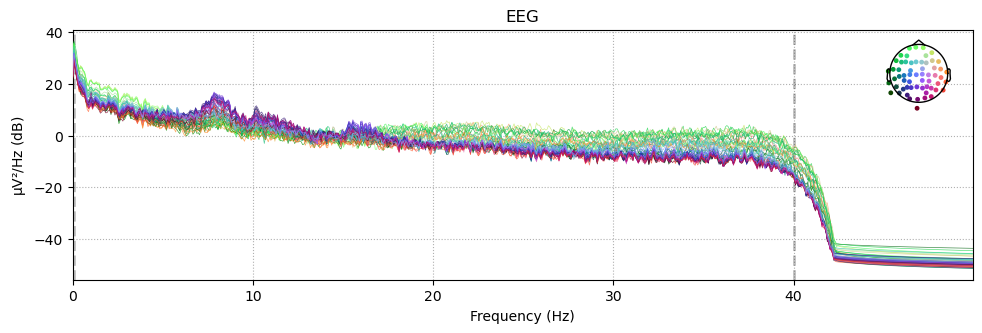

In [89]:
# We are plotting below 50 Hz because the sample data is low-pass filtered at 40 Hz
raw.plot_psd(fmax=50)

## Preprocessing
There is a lot of data within these EEG signals, therefore we'll clean up our data by performing independent components analysis where the compoenents that best capture the artifacts have already been determined.

In signal processing, independent component analysis is a computational method for separating a multivariate signal into additive subcomponents. This is done by assuming that at most one subcomponent is Gaussian and that the subcomponents are statistically independent from each other.

Typically used to remove artifacts such as blinking from EEG data.

Fitting ICA to data using 59 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 1.1s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated


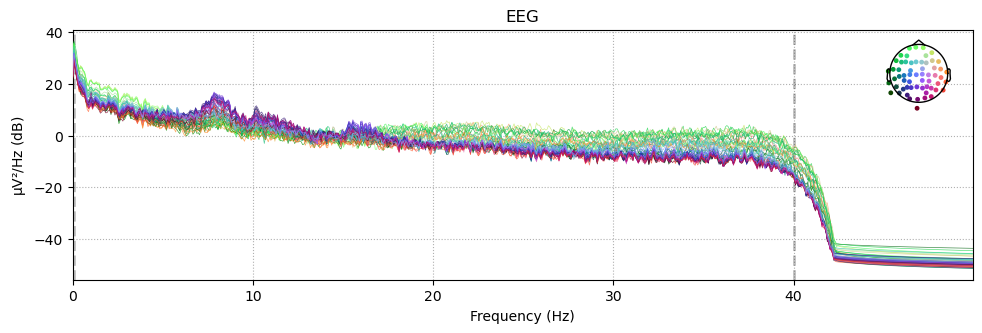

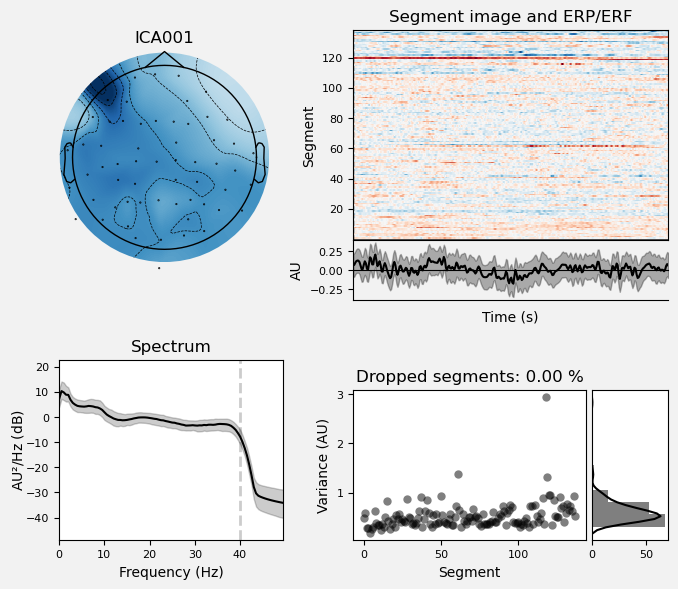

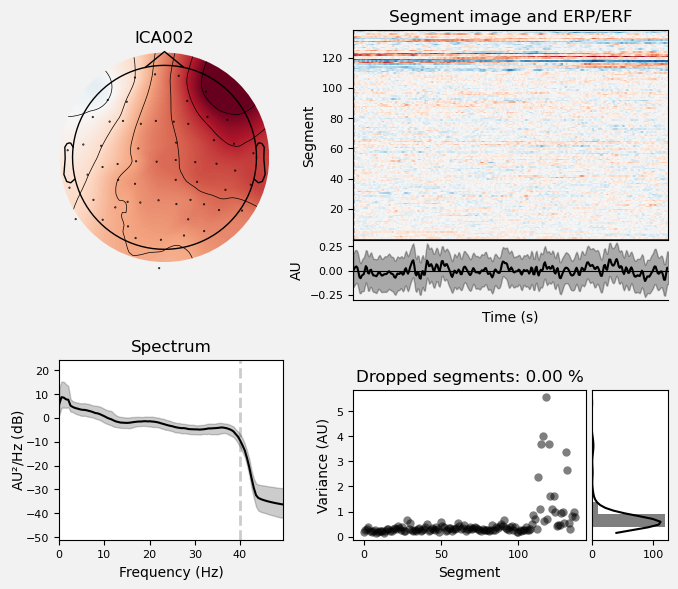

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [90]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [1, 2]  # details on how we picked these are omitted here
ica.plot_properties(raw, picks=ica.exclude)

## Events
Events are stored in 2D NumPy arrays, specifically for this sample dataset "STIM" channels <stim channel>`
that recorded electrical signals sent from the stimulus delivery computer (as
brief DC shifts / squarewave pulses). These pulses (often called "triggers")
are used in this dataset to mark experimental events: stimulus onset,
stimulus type, and participant response (button press). The individual STIM
channels are combined onto a single channel, in such a way that voltage
levels on that channel can be unambiguously decoded as a particular event
type.

In [91]:
sample_data_folder = mne.datasets.sample.data_path()
raw = mne.io.read_raw_fif('sample_audvis_raw.fif', verbose=False)

events = mne.find_events(raw, stim_channel='STI 014')
print(events[:5])  # show the first 5

320 events found
Event IDs: [ 1  2  3  4  5 32]
[[27977     0     2]
 [28345     0     3]
 [28771     0     1]
 [29219     0     4]
 [29652     0     2]]


We can map events using an event dictionary counting experimental conditions. In this experiment it is as follows:

In [92]:
event_dict = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
              'visual/right': 4, 'smiley': 5, 'buttonpress': 32}

Then we can plot in which these events occur.

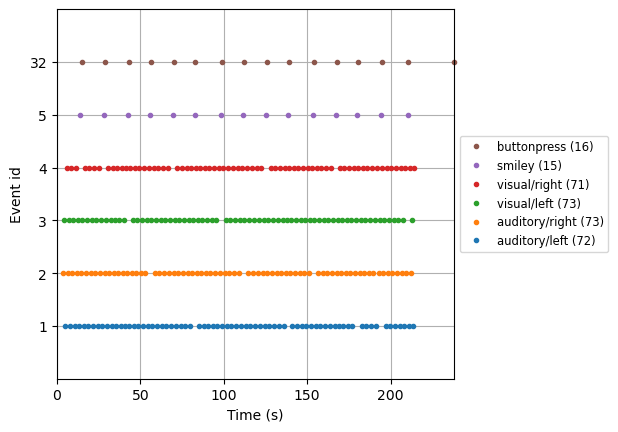

In [93]:
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp)

## Epochs
Epochs are specific time locked windows with respect an event. It is critical tha twe also reject epochs that peaks are simply beyond reasonable limits. 

In [94]:
# Specifically for this sample data
reject_criteria = dict(mag=4000e-15,     # 4000 fT
                       grad=4000e-13,    # 4000 fT/cm
                       eeg=150e-6,       # 150 µV
                       eog=250e-6)       # 250 µV

In [96]:
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.2, tmax=0.5,
                    reject=reject_criteria, preload=True)

Not setting metadata
320 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Loading data for 320 events and 421 original time points ...
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007', 'EEG 008', 'EEG 009', 'EEG 010', 'EEG 011', 'EEG 012', 'EEG 013', 'EEG 014', 'EEG 015', 'EEG 016', 'EEG 019', 'EEG 022', 'EEG 023']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007', 'EEG 010', 'EEG 013', 'EEG 014', 'EEG 015', 'EEG 016']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 

Clean up more to avoid bias of left or right auditory versus visual responses.

In [97]:
conditions = ['auditory/left', 'auditory/right',
                       'visual/left', 'visual/right']
epochs.equalize_event_counts(conditions) 
aud_epochs = epochs['auditory']
vis_epochs = epochs['visual']
del raw, epochs  # frees up memory

Dropped 23 epochs: 76, 92, 94, 95, 97, 106, 110, 111, 147, 164, 167, 168, 173, 176, 177, 178, 213, 218, 223, 227, 236, 237, 238


Finally we can plot the epochs!

Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated


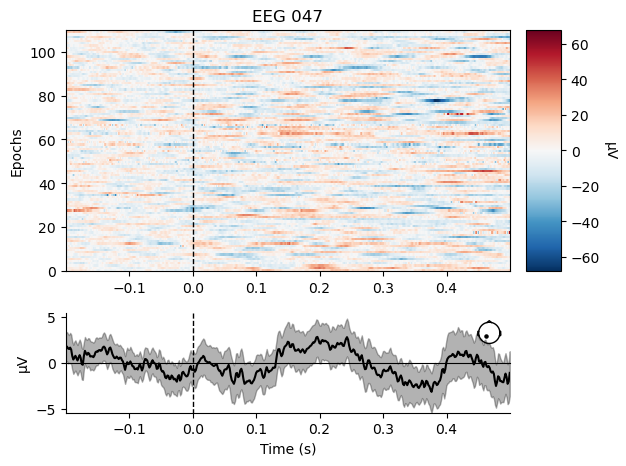

[<Figure size 640x480 with 4 Axes>]

In [98]:
aud_epochs.plot_image(picks=['EEG 047'])

## Estimate Events
In this sample dataset, we can get an estimate of evoked responses to auditory versus visual stimuli by averaging together the epochs in each condition. Below is a detailed representation of the evoked response to the stimulus. 

Projections have already been applied. Setting proj attribute to True.
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


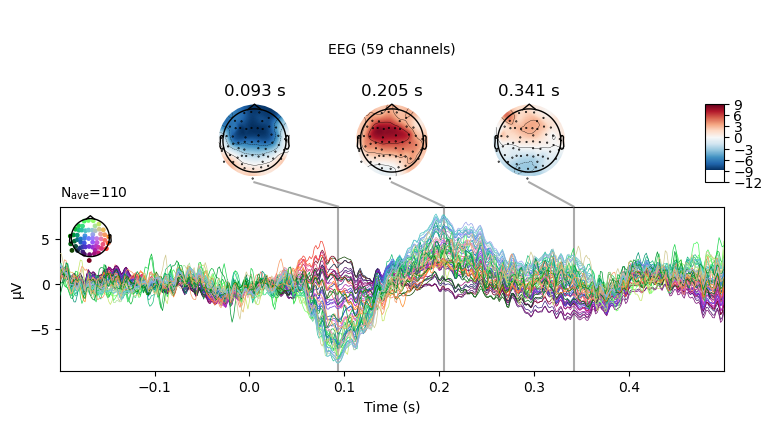

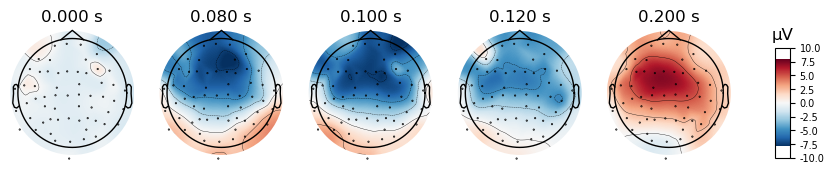

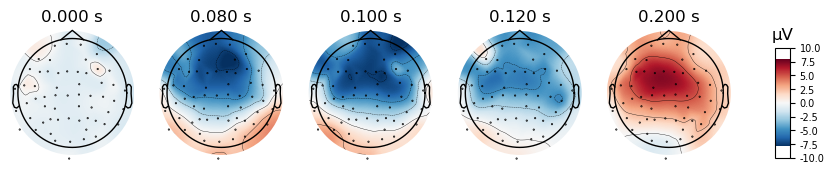

In [82]:
aud_evoked = aud_epochs.average()
vis_evoked = vis_epochs.average()

aud_evoked.plot_joint(picks='eeg')
aud_evoked.plot_topomap(times=[0., 0.08, 0.1, 0.12, 0.2], ch_type='eeg')

## Next Steps
Now it is your turn to try out the MNE-Python library! 

Some applications can be using it to analyze how different brain regions interact, machine learning to predict responses, neurological disorder analysis, etc.

Here are awesome resources to start exploring: 

https://www.frontiersin.org/articles/10.3389/fnins.2013.00267/full

https://medium.com/ai-techsystems/analyzing-eeg-brainwave-data-to-detect-emotions-on-cainvas-48833f3f0811

https://medium.com/building-a-bedroom-bci/experimenting-with-machine-learning-for-eeg-data-ed4059a1e320